# 2 Write a DES program to verify this for n=1, n=2 and n=4. Make sure that your result has a high and known statistical significance. How does the number of measurements required to attain this depend on ρ?

In [ ]:
pip install SimPy

In [ ]:
pip install progress

## 2.1 Define the code for the process

In [ ]:
from google.colab import drive
import simpy
import random
import numpy as np
from progressbar import ProgressBar
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
plt.style.use('ggplot')
from progress.bar import Bar
plt.rcParams["figure.figsize"]=10,5
plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 
text_size = 25
line_width = 2.5


# Mount Drive to the Colab VM.
drive.mount('/drive')
path = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 2"
path_figures = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 2/Figures"

# function for reading files from a directory
def read_files_dir(path):
  '''function for reading and combining files in a directory'''
  os.chdir(path)
  file_list = os.listdir()
  df_1 = pd.DataFrame()
  for i in file_list:
    if i[len(i)-3:len(i)] != "csv":
      continue
    print(i)
    data = pd.read_csv(i)
    data["file"] = i
    df_1 = pd.concat([df_1, data])
  return df_1

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


### 2.1.2  Define code for simulating multiple times

In [ ]:
def simulate(no_of_customers, rho, mu, n_servers, n_simulations, time = np.inf, unlimited = False, with_priority = False, deterministic = False, D = 10, hyper = False, high_hyper = 5, low_hyper = 1):
    '''A function for running queue simulations.
    With default setting it is M/M/n simulation with FIFO. 
    With with_priority = True - M/M/n with shortest job first priority
    With deterministic = True - M/D/n model with FIFO with D mean service time
    With hyper = true - M/H/n model with FIFO
    If n_simulations = 1, returns a list of all waiting times in the simulation, if n_simulationds > 1, returns a list of mean waiting times for each simulation'''
    import simpy
    import random
    import numpy as np
    from progressbar import progressbar
    pbar = ProgressBar()
    if hyper == True:
      mu = 0.75 * 1/low_hyper + 0.25 * 1/high_hyper
      mu = 1/mu
    rate_arrival_lambda = n_servers*rho*mu # calculate arrival lambda
    mean_wait_times = [] # create a list of mean wait times
    for i in range(n_simulations): # run simulation n_simulations times
        def generate_customer(env, servers, lambda_arrive, mu_serve, unlimited = True, with_priority = False, deterministic = False, D = 10, hyper = False, high_hyper = 5, low_hyper = 1):
            if unlimited == True:
                i = 0
                while True:
                    t = random.expovariate(lambda_arrive)
                    if deterministic == False:
                      time_to_server = random.expovariate(mu_serve)
                    else:
                      time_to_server = D
                    if hyper == True:
                      if random.uniform(0,1) > 0.75:
                        time_to_server = random.expovariate(high_hyper)
                      else:
                        time_to_server = random.expovariate(low_hyper)
                    P = 1.0/time_to_server
                    yield env.timeout(t)
                    if with_priority == True:
                      env.process(customer(env, i, servers, mu_serve, time_to_server, P))
                    else:
                      env.process(customer(env, i, servers, mu_serve, time_to_server, P = 1))
                    i += 1
            else:
                for i in progressbar(range(no_of_customers)):
                  t = random.expovariate(lambda_arrive)
                  if deterministic == False:
                    time_to_server = random.expovariate(mu_serve)
                  else:
                    time_to_server = D
                  if hyper == True:
                    if random.uniform(0,1) > 0.75:
                      time_to_server = random.expovariate(high_hyper)
                    else:
                      time_to_server = random.expovariate(low_hyper)
                  P = 1.0/time_to_server
                  yield env.timeout(t)
                  if with_priority == True:
                    env.process(customer(env, i, servers, mu_serve, time_to_server, P))
                  else:
                    env.process(customer(env, i, servers, mu_serve, time_to_server, P = 1))
                
        def customer(env, name, servers, mu_serve, time_to_server, P = 1):
            #print("Customer %s arrived at time %.1f with priority %s" % (name, env.now, P))
            with servers.request(priority = -1*P) as req:
                start_serving = env.now
                yield req
                #print("Customer %s started at time %.1f" % (name, env.now))
                server_wait_times.append(env.now-start_serving)
                yield env.timeout(time_to_server)
                
        env = simpy.Environment()
        servers = simpy.PriorityResource(env, n_servers) 
        server_wait_times = []
        env.process(generate_customer(env, servers, rate_arrival_lambda, mu, unlimited = unlimited, with_priority=with_priority, deterministic=deterministic, D=D, hyper = hyper, high_hyper = high_hyper, low_hyper = low_hyper))
        env.run(until=time)
        mean_wait_time = np.mean(server_wait_times)
        mean_wait_times.append(mean_wait_time)
    if n_simulations == 1:
      return server_wait_times
    if n_simulations > 1:
      return mean_wait_times

## 2.2 Theoretical mean waiting time in the queue

In [ ]:
# M/M/n
def pi_w(c, rho):
  summ = []
  for i in range(c):
    summ.append((c*rho)**i/(np.math.factorial(i)))
  return (c*rho)**c/(np.math.factorial(c)) * ((1-rho)*sum(summ)+(c*rho)**c/(np.math.factorial(c)))**(-1)

def Ew(c, rho, mu):
  ''' c - number of servers,
  returns theretical waiting time for M/M/n queues'''
  return pi_w(c,rho)*1/(1-rho)*1/(c*mu)

# M/M/1 with shortest job first priority
from scipy.integrate import quad
def theo_wait_priority(rho, mu):
  '''returns theretical waiting time for M/M/n queues with shortest job first priority'''
  def integrand(x, rho):
      return np.e**(-1*x)/(1-rho*(1-np.e**(-1*x)-x*np.e**(-x)))**2
  I = quad(integrand, 0, np.inf, args=(rho))
  return I[0]*rho*(1/mu)

# M/D/1
def theo_mdn(s, mu, rho):
  '''s - number of servers
  returns theretical waiting time for M/D/n '''
  return Ew(s, rho, mu)/2

In [ ]:
mu = 1/1.25
num_of_servers = 1
base_interval_arrival = 1.3
rate_arrival_lambda = num_of_servers/base_interval_arrival
rho =  (rate_arrival_lambda)/(num_of_servers*mu)

num_of_servers = 1
rho = 0.90
E_w = pi_w(num_of_servers,rho)*1/(1-rho)*1/(num_of_servers*mu)
print(rho,E_w) 

0.9 11.250000000000002
23.749999999999975


In [ ]:
0.25*

# 2.3.1 Simulating average waiting time for a range of customers, 50 times

#### 2.3.1.1 M/M/1

In [ ]:
mu = 1/1.25
n_simulations_inner = 50
n_simulations_outter = 1
no_of_customers=[100, 500, 1000, 5000, 10000, 50000, 100000, 250000, 500000] 
path_MMn = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 2/2. M_M_n/mean_wait_time"
server_n = [1]
rhos = [0.5, 0.8, 0.9, 0.95]

for rho in rhos:
  for num_of_servers in server_n:
    df = pd.DataFrame()
    for sim in range(n_simulations_outter):
      for num in (no_of_customers):
        server_wait_times = simulate(num, rho, mu, n_servers=num_of_servers,n_simulations=n_simulations_inner, unlimited=False)
        dict_df = {
            "sim" : sim,
            "rho" : rho,
            "customer_no" : num,
            "servers" : num_of_servers,
            "mean_waiting_time" : server_wait_times
        }
        df_inner = pd.DataFrame(dict_df)
        df = df.append(df_inner)
    now = datetime.now()
    df.to_csv(f"{path_MMn}/mean_waiting_time, simulations_inner={n_simulations_inner}, servers={num_of_servers}, rho={rho}, customers={no_of_customers}, date={now}.csv", index=False)

#### 2.3.1.2 M/D/1

In [ ]:
mu = 1/1.25
n_simulations_inner = 50
n_simulations_outter = 1
no_of_customers=[100, 500, 1000, 5000, 10000, 50000, 100000, 250000, 500000] 
path_MDn = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 2/4. Other types/4.1 M_D_n/correct/"
server_n = [1]
rhos = [0.5, 0.8, 0.9, 0.95]

for rho in rhos:
  for num_of_servers in server_n:
    df = pd.DataFrame()
    for sim in range(n_simulations_outter):
      for num in (no_of_customers):
        server_wait_times = simulate(num, rho, mu, n_servers=num_of_servers,n_simulations=n_simulations_inner, deterministic=True, D = mu)
        dict_df = {
            "sim" : sim,
            "rho" : rho,
            "customer_no" : num,
            "servers" : num_of_servers,
            "mean_waiting_time" : server_wait_times
        }
        df_inner = pd.DataFrame(dict_df)
        df = df.append(df_inner)
    now = datetime.now()
    df.to_csv(f"{path_MDn}/mean_waiting_time, simulations_inner={n_simulations_inner}, servers={num_of_servers}, rho={rho}, customers={no_of_customers}, date={now}.csv", index=False)

#### 2.3.1.3 M/H/1

In [ ]:
mu = 1/1.25
n_simulations_inner = 50
n_simulations_outter = 1
no_of_customers=[100, 500, 1000, 5000, 10000, 50000, 100000, 250000, 500000] 
path_MHn = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 2/4. Other types/4.2 M_H_n/correct/"
server_n = [1]
rhos = [0.5, 0.8, 0.9, 0.95]

for rho in rhos:
  for num_of_servers in server_n:
    df = pd.DataFrame()
    for sim in range(n_simulations_outter):
      for num in (no_of_customers):
        server_wait_times = simulate(num, rho, mu, n_servers=num_of_servers,n_simulations=n_simulations_inner, hyper = True, high_hyper=1/3.5, low_hyper=1/0.5)
        dict_df = {
            "sim" : sim,
            "rho" : rho,
            "customer_no" : num,
            "servers" : num_of_servers,
            "mean_waiting_time" : server_wait_times
        }
        df_inner = pd.DataFrame(dict_df)
        df = df.append(df_inner)
    now = datetime.now()
    df.to_csv(f"{path_MHn}/mean_waiting_time, simulations_inner={n_simulations_inner}, servers={num_of_servers}, rho={rho}, customers={no_of_customers}, date={now}.csv", index=False)

#### 2.3.1.3 M/M/1 with priority

In [ ]:
mu = 1/1.25
n_simulations_inner = 50
n_simulations_outter = 1
no_of_customers=[100, 500, 1000, 5000, 10000, 50000, 100000, 250000, 500000] 
path_MNn_prio = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 2/3. Shortest job first/for std/"
server_n = [1]
rhos = [0.5, 0.8, 0.9, 0.95]

for rho in rhos:
  for num_of_servers in server_n:
    df = pd.DataFrame()
    for sim in range(n_simulations_outter):
      for num in (no_of_customers):
        server_wait_times = simulate(num, rho, mu, n_servers=num_of_servers,n_simulations=n_simulations_inner, with_priority=True)
        dict_df = {
            "sim" : sim,
            "rho" : rho,
            "customer_no" : num,
            "servers" : num_of_servers,
            "mean_waiting_time" : server_wait_times
        }
        df_inner = pd.DataFrame(dict_df)
        df = df.append(df_inner)
    now = datetime.now()
    df.to_csv(f"{path_MNn_prio}/mean_waiting_time, simulations_inner={n_simulations_inner}, servers={num_of_servers}, rho={rho}, customers={no_of_customers}, date={now}.csv", index=False)

## 2.3.2 Find the mean, variance, CI and perform normality test - M/M/1, M/D/1,M/H/1, M/M/1 with priority

In [ ]:
# read the data
path_MMn = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 2/2. M_M_n/mean_wait_time"
MMn = read_files_dir(path_MMn)
MMn["type"] = "MMn"
path_MDn = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 2/4. Other types/4.1 M_D_n/correct/"
MDn = read_files_dir(path_MDn)
MDn["type"] = "MDn"
path_MHn = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 2/4. Other types/4.2 M_H_n/correct/"
MHn = read_files_dir(path_MHn)
MHn["type"] = "MHn"
path_MMn_priority = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 2/3. Shortest job first/for std/"
MMn_prio = read_files_dir(path_MMn_priority)
MMn_prio["type"] = "MMn-priority"
MMn_prio.head(5)

### 2.3.2.1 Create function that gives all relavent statistics

In [ ]:
def get_norm_std(data):
  '''returns mean waiting type, confidence interval, normality p and theoretical waiting times'''
  rhos = np.unique(data.rho)
  customer_nos = np.unique(data.customer_no)
  types = np.unique(data.type)
  servers = np.unique(data.servers)
  rhos_ordered = []
  c_n_ordered = []
  servers_ordered = []
  types_ordered = []
  p_values = []
  stds = []
  means = []
  ci_s = []
  for rho in rhos:
    for c_n in customer_nos:
      for s in servers:
        for type in types:
          data_filtered = data[(data.rho == rho) & (data.customer_no == c_n) & (data.servers == s) & (data.type == type)].mean_waiting_time
          if len(data_filtered) == 0:
            continue
          _, p_value = st.shapiro(data_filtered)
          stds.append(np.std(data_filtered))
          means.append(np.mean(data_filtered))
          ci = np.std(data_filtered)/(len(data_filtered))**(0.5) * 1.96  # confidence interval
          ci_interval = (np.round(np.mean(data_filtered) - ci,3), np.round(np.mean(data_filtered) + ci,3))
          ci_s.append(ci_interval)
          servers_ordered.append(s)
          types_ordered.append(type)
          rhos_ordered.append(rho)
          c_n_ordered.append(c_n)
          p_values.append(p_value)
  df_dict = {
      "rho" : np.round(rhos_ordered, 3),
      "c" : c_n_ordered,
      "s" : servers_ordered,
      "type" : types_ordered,
      "mean_time" : np.round(means, 3),
      "ci" :  ci_s,
      "p_normality" : np.round(p_values, 3),
      "std" : np.round(stds, 3)
  }
  df = pd.DataFrame(df_dict).sort_values(by = ["type", "rho", "c", "s"])
  # calculate the theoretical values
  mu = 1/1.25
  theoretical_wait_times = []
  for index, row in df.iterrows():
    if row["type"] == "M/D/n":
      theoretical_wait_times.append(theo_mdn(row["s"], mu, row["rho"]))
    elif row["type"] == "M/M/n":
      theoretical_wait_times.append(Ew(row["s"],row["rho"], mu))
    elif row["type"] == "M/M/n-priority":
      theoretical_wait_times.append(theo_wait_priority(row["rho"], mu))
    else:
      theoretical_wait_times.append(np.nan)
  df["theoretical_wait_time"] = np.round(theoretical_wait_times, 3)
  return df

## 2.4 Create standard deviation plots for all models with 1 server

In [ ]:
df_MMn = get_norm_std(MMn)
df_MDn = get_norm_std(MDn)
df_MHn = get_norm_std(MHn)
df_MMn_prio = get_norm_std(MMn_prio)

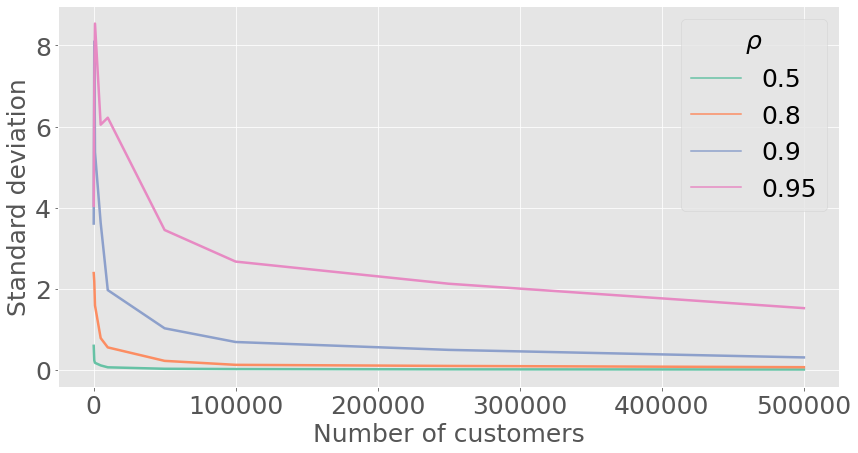

In [ ]:
# MMn
plt.figure(figsize=(14,7))
ax = sns.lineplot(data = df_MMn, x = "c", y = "std", hue = "rho", palette = "Set2", linewidth = line_width)
ax.set_xlabel('Number of customers', size = text_size) 
ax.set_ylabel('Standard deviation', size = text_size)
ax.legend(title = "$\\rho$", fontsize=text_size, title_fontsize=text_size)
plt.savefig(path_figures+"/std, MM1.pdf", bpi = 3000)
plt.show()

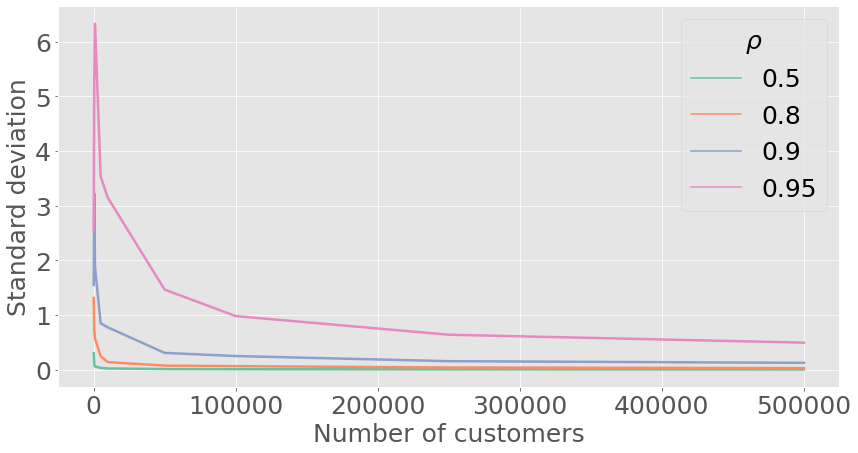

In [ ]:
# MDn
plt.figure(figsize=(14,7))
ax = sns.lineplot(data = df_MDn, x = "c", y = "std", hue = "rho", palette = "Set2", linewidth = line_width)
ax.set_xlabel('Number of customers', size = text_size) 
ax.set_ylabel('Standard deviation', size = text_size)
ax.legend(title = "$\\rho$", fontsize=text_size, title_fontsize=text_size)
plt.savefig(path_figures+"/std, MD1.pdf", bpi = 3000)
plt.show()

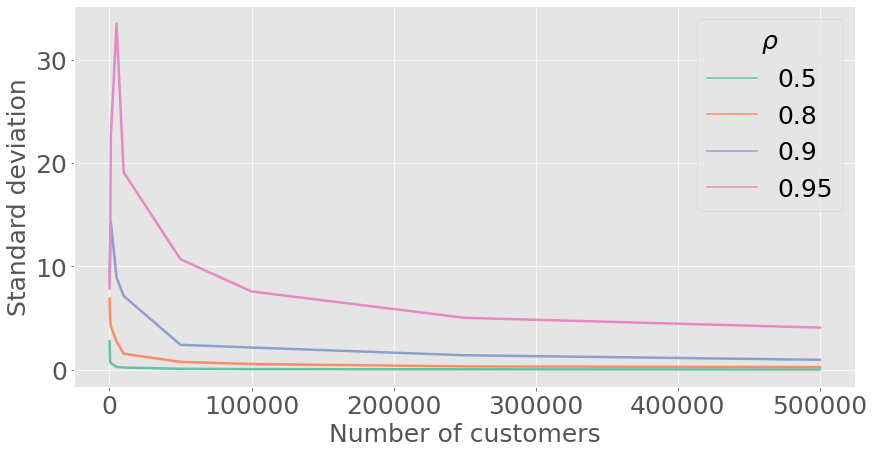

In [ ]:
# MHn
plt.figure(figsize=(14,7))
ax = sns.lineplot(data = df_MHn, x = "c", y = "std", hue = "rho", palette = "Set2", linewidth = line_width)
ax.set_xlabel('Number of customers', size = text_size) 
ax.set_ylabel('Standard deviation', size = text_size)
ax.legend(title = "$\\rho$", fontsize=text_size, title_fontsize=text_size)
plt.savefig(path_figures+"/std, MH1.pdf", bpi = 3000)
plt.show()

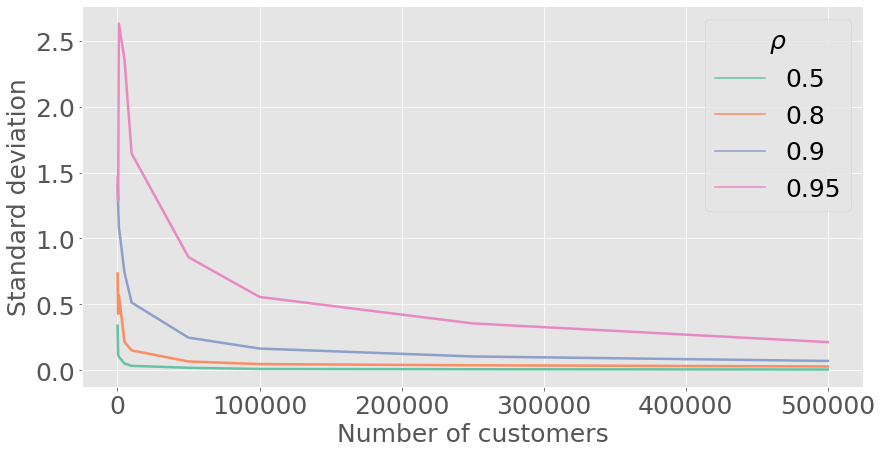

In [ ]:
# MMn priority
plt.figure(figsize=(14,7))
ax = sns.lineplot(data = df_MMn_prio, x = "c", y = "std", hue = "rho", palette = "Set2", linewidth = line_width)
ax.set_xlabel('Number of customers', size = text_size) 
ax.set_ylabel('Standard deviation', size = text_size)
ax.legend(title = "$\\rho$", fontsize=text_size, title_fontsize=text_size)
plt.savefig(path_figures+"/std, MM1 priority.pdf", bpi = 3000)
plt.show()

# 3 run a 100 simulations with 500k customers for all models with rho = 0.95 and servers = 1, 2, 4

## 3.1 M/M/n

In [ ]:
# choose c as 500 000 and run 100 simulations for each rho and server combo for MMn
path_MMn_sims = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 2/2. M_M_n/100 sims/2"
c = 500000
sims = 100
mu = 1/1.25
server_n = [1,2,4]
rhos = [0.5, 0.8]

for s_n in server_n:
  for rho in rhos:
    df = pd.DataFrame()
    mean_wait_times = simulate(c, rho, mu, s_n, sims)
    df_dict = {
      "rho" : rho,
      "customer_no" : c,
      "servers" : s_n,
      "mean_waiting_time" : mean_wait_times,
    }
    df_in = pd.DataFrame(df_dict)
    df = df.append(df_in)
    now = datetime.now()
    df.to_csv(f"{path_MMn_sims}/mean_waiting_time, simulations_inner={sims}, servers={s_n}, rho={rho}, customers={c}, date={now}.csv", index=False)


## 3.2 M/D/n

In [ ]:
# choose c as 500 000 and run 100 simulations for each rho and server combo for MDn
path_MDn_sims = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 2/4. Other types/4.1 M_D_n/correct/100 sims/2"
c = 500000
sims = 100
mu = 1/1.25
server_n = [1,2,4]
rhos = [0.5, 0.8]

for s_n in server_n:
  for rho in rhos:
    df = pd.DataFrame()
    mean_wait_times = simulate(c, rho, mu, s_n, sims, deterministic=True, D = mu)
    df_dict = {
      "rho" : rho,
      "customer_no" : c,
      "servers" : s_n,
      "mean_waiting_time" : mean_wait_times,
    }
    df_in = pd.DataFrame(df_dict)
    df = df.append(df_in)
    now = datetime.now()
    df.to_csv(f"{path_MDn_sims}/mean_waiting_time, simulations_inner={sims}, servers={s_n}, rho={rho}, customers={c}, date={now}.csv", index=False)


## 3.3 M/H/n

In [ ]:
# choose c as 500 000 and run 100 simulations for each rho and server combo for MHn
path_MHn_sims = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 2/4. Other types/4.2 M_H_n/correct/100 sims/2"
c = 500000
sims = 100
mu = 1/1.25
server_n = [1,2,4]
rhos = [0.5, 0.8]

for s_n in server_n:
  for rho in rhos:
    df = pd.DataFrame()
    mean_wait_times = simulate(c, rho, mu, s_n, sims, hyper = True, high_hyper= 1/3.5, low_hyper= 1/0.5)
    df_dict = {
      "rho" : rho,
      "customer_no" : c,
      "servers" : s_n,
      "mean_waiting_time" : mean_wait_times,
    }
    df_in = pd.DataFrame(df_dict)
    df = df.append(df_in)
    now = datetime.now()
    df.to_csv(f"{path_MHn_sims}/mean_waiting_time, simulations_inner={sims}, servers={s_n}, rho={rho}, customers={c}, date={now}.csv", index=False)


## 3.4 M/M/n with priority

In [ ]:
# choose c as 500 000 and run 100 simulations for each rho and server combo for MHn
path_MMnprio_sims = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 2/3. Shortest job first/"
c = 500000
sims = 100
mu = 1/1.25
server_n = [1,2,4]
rhos = [0.5, 0.8]

for s_n in server_n:
  for rho in rhos:
    df = pd.DataFrame()
    mean_wait_times = simulate(c, rho, mu, s_n, sims, with_priority=True)
    df_dict = {
      "rho" : rho,
      "customer_no" : c,
      "servers" : s_n,
      "mean_waiting_time" : mean_wait_times,
    }
    df_in = pd.DataFrame(df_dict)
    df = df.append(df_in)
    now = datetime.now()
    df.to_csv(f"{path_MMnprio_sims}/mean_waiting_time, simulations_inner={sims}, servers={s_n}, rho={rho}, customers={c}, date={now}.csv", index=False)


## 3.5 read all 100 simulations data generated

In [ ]:
path_MMn_100 = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 2/2. M_M_n/100 sims/2"
MMn_100 = read_files_dir(path_MMn_100)
MMn_100["type"] = "M/M/n"
# read old run of MMn server 1
path_MMn_100_old = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 2/2. M_M_n/100 sims/2/old run for server = 1"
MMn_100_old = read_files_dir(path_MMn_100_old)
MMn_100_old = MMn_100_old.rename(columns = {"c": "customer_no", "s" : "servers", "mean_wait_time" : "mean_waiting_time"})
MMn_100_old["type"] = "M/M/n"
path_MDn_100 = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 2/4. Other types/4.1 M_D_n/correct/100 sims/2"
MDn_100 = read_files_dir(path_MDn_100)
MDn_100["type"] = "M/D/n"
path_MHn_100 = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 2/4. Other types/4.2 M_H_n/correct/100 sims/2"
MHn_100 = read_files_dir(path_MHn_100)
MHn_100["type"] = "M/H/n"
path_MMnprio_100 = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 2/3. Shortest job first/"
MHnprio_100 = read_files_dir(path_MMnprio_100)
MHnprio_100 = MHnprio_100.rename(columns = {"c": "customer_no", "s" : "servers", "mean_wait_time" : "mean_waiting_time"})
MHnprio_100["type"] = "M/M/n-priority"
full_100_sims = pd.concat([MMn_100, MMn_100_old, MDn_100, MHn_100, MHnprio_100])
# filter for 1 server only
sims_100_s1 = full_100_sims[full_100_sims.servers == 1].copy()
sims_100_s1.head()

## 3.6 create normality plots

In [ ]:
# plot normality 
plt.rcParams["figure.figsize"]=10,5
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
text_size = 25
line_width = 2.5
g = sns.FacetGrid(sims_100_s1, row="rho", col="type", sharey=False, sharex=False)
g.map(sns.distplot, "mean_waiting_time", kde=True)
plt.savefig(path_figures+"/normality big.pdf", bpi = 3000)
plt.show()

## 3.7 get statistics for the 100 simulations

In [ ]:
df = get_norm_std(full_100_sims)

### for rho = 0.95 and all server_n, MMn and MM1 priority

In [ ]:
filtered = df[(df.rho == 0.95) & ((df.type == "M/M/n") | (df.type == "M/M/n-priority"))]
final = filtered[["type", "mean_time", "theoretical_wait_time", "ci", "p_normality"]]
final.to_latex(index = False)

### for all rho and all server = 1, MDn and MHn priority

In [ ]:
filtered = df[((df.type == "M/D/n") | (df.type == "M/H/n"))]
final = filtered[["type", "mean_time", "theoretical_wait_time", "ci", "p_normality"]]
final.to_latex(index = False)

### Table for appendix - mean waiting times for remaining models

In [ ]:
filtered = df[((df.type == "M/M/n") | (df.type == "M/M/n-priority"))]
final = filtered[["type", "rho", "mean_time", "theoretical_wait_time", "ci", "p_normality"]]
final.to_latex(index = False)

### Table for appendix - t-tests inside models

In [ ]:
import scipy.stats as stat

filtered = full_100_sims[(full_100_sims.rho == 0.95)]
pairs = [(1, 2), (2, 4), (1, 4)]

p_values = []
types_ordered = []
server_1_ordered = []
server_2_ordered = []
types = np.unique(filtered.type)

for type in types:
  filtered_type = filtered[(filtered.type == type)]
  for pair in pairs:
    if type == 'M/M/n-priority':
      continue
    filtered_type_1 = filtered_type[filtered_type.servers == pair[0]].mean_waiting_time
    filtered_type_2 = filtered_type[filtered_type.servers == pair[1]].mean_waiting_time
    p_value = stat.ttest_ind(filtered_type_1, filtered_type_2, equal_var = False)[1]
    server_1_ordered.append(pair[0])
    server_2_ordered.append(pair[1])
    p_values.append(p_value)
    types_ordered.append(type)

In [ ]:
df_dict = {
  "Model" : types_ordered,
  "Servers_1" : server_1_ordered,
  "Servers_2" : server_2_ordered,
  "p-value" : p_values
}
t_test = pd.DataFrame(df_dict)
t_test.to_latex(index = False)

### Table for appendix - t-tests between M/M/1 and M/M/1 with priority

In [ ]:
MMn_ttest = full_100_sims[(full_100_sims.type == "M/M/n") & (full_100_sims.servers == 1)]
MMnprio_ttest = full_100_sims[(full_100_sims.type == 'M/M/n-priority') & (full_100_sims.servers == 1)]

p_values = []
types_ordered = []
server_1_ordered = []
rhos_ordered = []
rhos = np.unique(MMn_ttest.rho)

for rho in rhos:
  MMn_ttest_filtered = MMn_ttest[(MMn_ttest.rho == rho)].mean_waiting_time
  MMnprio_ttest_filtered = MMnprio_ttest[(MMnprio_ttest.rho == rho)].mean_waiting_time
  p_value = stat.ttest_ind(MMn_ttest_filtered, MMnprio_ttest_filtered, equal_var = False)[1]
  rhos_ordered.append(rho)
  p_values.append(p_value)


In [ ]:
df_dict = {
  "rho" : rhos_ordered,
  "p-value" : p_values
}
t_test = pd.DataFrame(df_dict)
t_test.to_latex(index = False)